# Лабораторная работа №2

Задания:
- Выберите временной ряд с ценами актива (предпочтительно с явной сезонностью, например, акции компании с сезонным бизнесом).

- Проведите декомпозицию временного ряда на тренд, сезонность и остаток. Визуализируйте компоненты декомпозиции.

- Проанализируйте сезонность: определите периодичность и амплитуду сезонных колебаний.

- Удалите сезонность из ряда и сравните исходный ряд с десезонализированным.

- Постройте прогноз на основе выявленных тренда и сезонности на 12 периодов вперед. Оцените качество прогноза, используя метрики MAE и RMSE. Сделайте выводы о влиянии сезонности на цены актива и эффективности прогнозирования.

- Проведите тест на стационарность ряда (тест Дики-Фуллера). Если ряд нестационарен, приведите его к стационарному виду.

- Постройте и сравните модели AR, MA, ARMA и ARIMA. Подберите оптимальные параметры для каждой модели, используя информационные критерии (AIC, BIC).

- Проведите диагностику остатков моделей. Сделайте прогноз на 30 дней вперед для каждой модели. Сравните качество прогнозов моделей, используя метрики MAE, RMSE и MAPE. Визуализируйте результаты прогнозирования. Сделайте выводы о применимости различных авторегрессионных моделей к ценам криптовалют.

## Подключение и преднастройка необходимых компонент

Подключение Google Drive

In [9]:
%%time
# монтируем диск
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CPU times: user 26.4 ms, sys: 254 µs, total: 26.7 ms
Wall time: 1.8 s


Подключение глобально необходимых библиотек

In [10]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Описание набора данных
Этот набор данных содержит данные цен на газ за месяц с 1997 по 2020 г.

## Декомпозиция временного ряда

In [11]:
warnings.simplefilter('ignore')

data = pd.read_csv("/content/drive/MyDrive/monthly_csv.csv", parse_dates=True, index_col="Month")
target_column = 'Price'

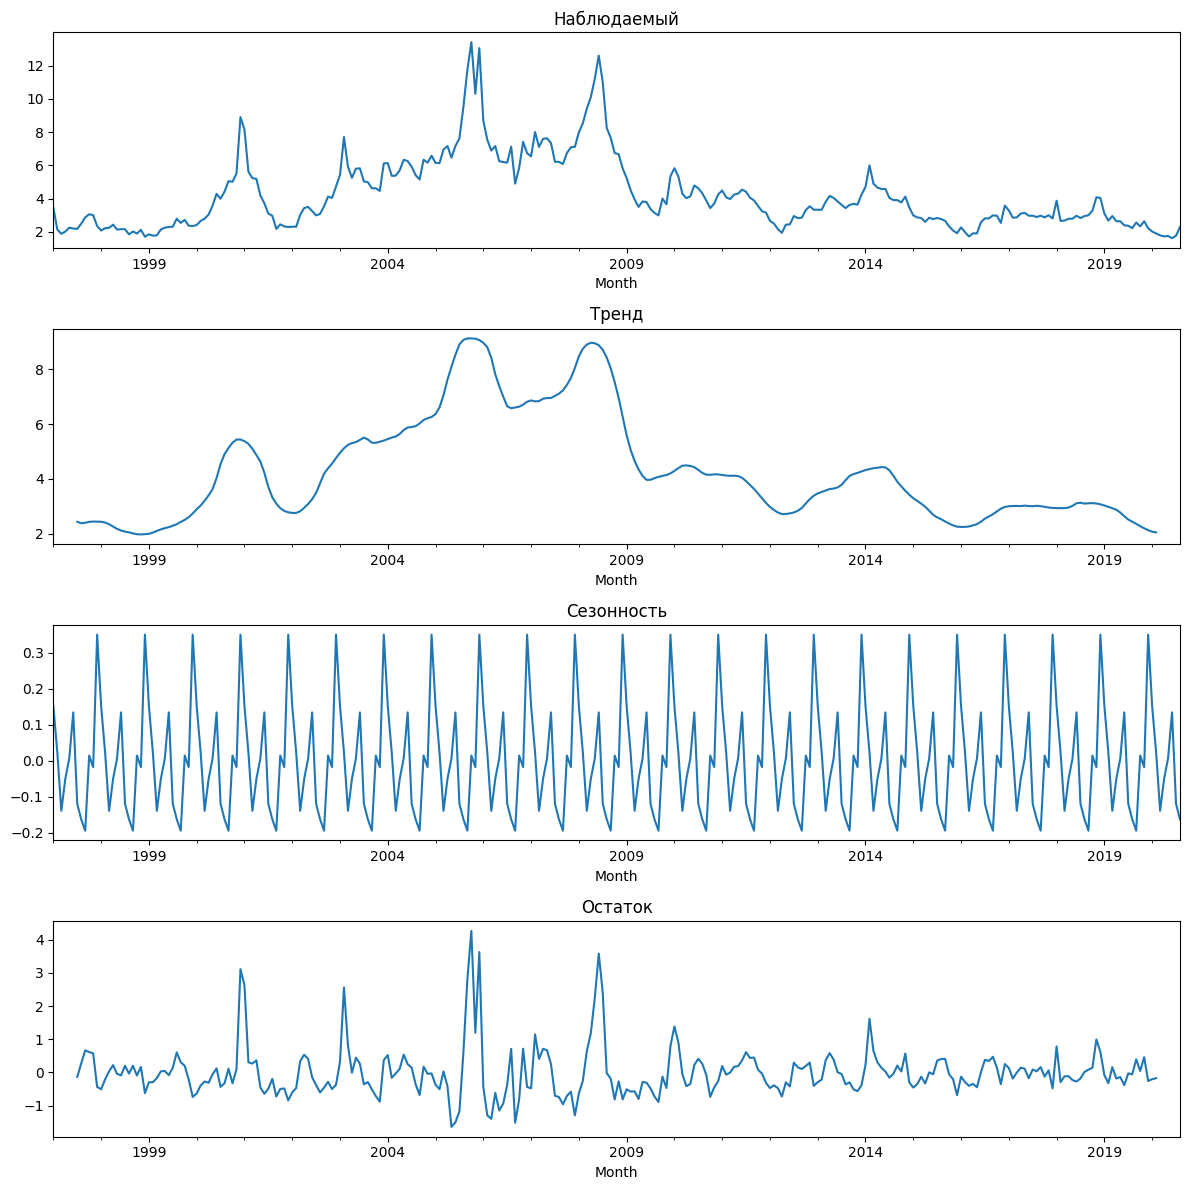

In [12]:
decomposition = seasonal_decompose(data[target_column], model='additive')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Наблюдаемый')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Тренд')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Сезонность')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Остаток')
plt.tight_layout()
plt.show()


Наблюдаемый временной ряд демонстрирует цикличность, с периодическими подъемами и спадами.

До 2008 года наблюдается ярко выраженный циклический тренд с пиками и спадами.
С 2003 по 2005 год наблюдается умеренный рост.
После 2008 года тренд становится более хаотичным, с чередованием периодов роста и падения.

На графике сезонности видна ярко выраженная цикличность с периодом в один год.
Каждый год наблюдается:
- Рост цен в конце года, достигающий пика примерно на уровне 0,3.
- Падение в начале следующего года, примерно до -0,4.
- Повторный рост, примерно до 0,2.


## Прогнозирование с учётом тренда и сезонности
Для прогнозирования с учётом тренда и сезонности можно воспользоваться методом экспоненциального сглаживания.
С целью минимизации влияния высокоамплитудных колебаний, наблюдаемых в первой половине временного ряда, для расчетов будет использована только вторая половина данных.

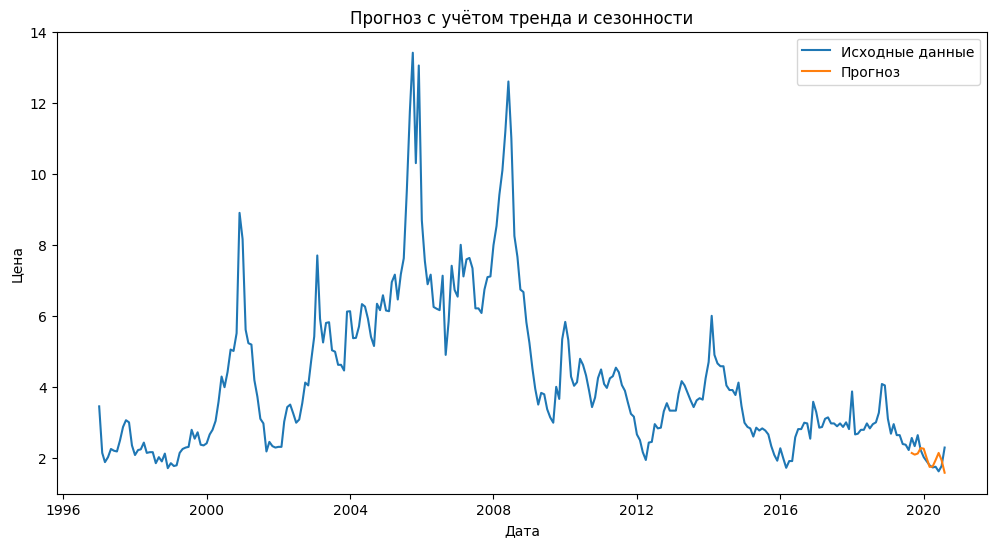

In [13]:
model = ExponentialSmoothing(data.iloc[-150:-12][target_column], trend='add', seasonal='add', seasonal_periods=12).fit()
forecast = model.forecast(12)
plt.figure(figsize=(12, 6))
plt.plot(data[target_column], label='Исходные данные')
plt.plot(data.index[-12:], forecast, label='Прогноз')
plt.title('Прогноз с учётом тренда и сезонности')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()


In [14]:
def get_stats(data, forecast, length):
    mae = mean_absolute_error(data.iloc[-length:], forecast)
    rmse = np.sqrt(mean_squared_error(data.iloc[-length:], forecast))
    mape = mean_absolute_percentage_error(data.iloc[-length:], forecast)
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("MAPE:", mape)

get_stats(data[target_column],forecast,12)

MAE: 0.2676453098348303
RMSE: 0.34264325773281784
MAPE: 0.12690757252297544


Значения MAE и RMSE может быть интерпретировано как относительно низкое, что указывает на хорошую точность прогноза.


В данном случае прогноз демонстрирует достаточно неплохие результаты, хотя в последней части и существенно расходится с действительностью.

## График без сезонности

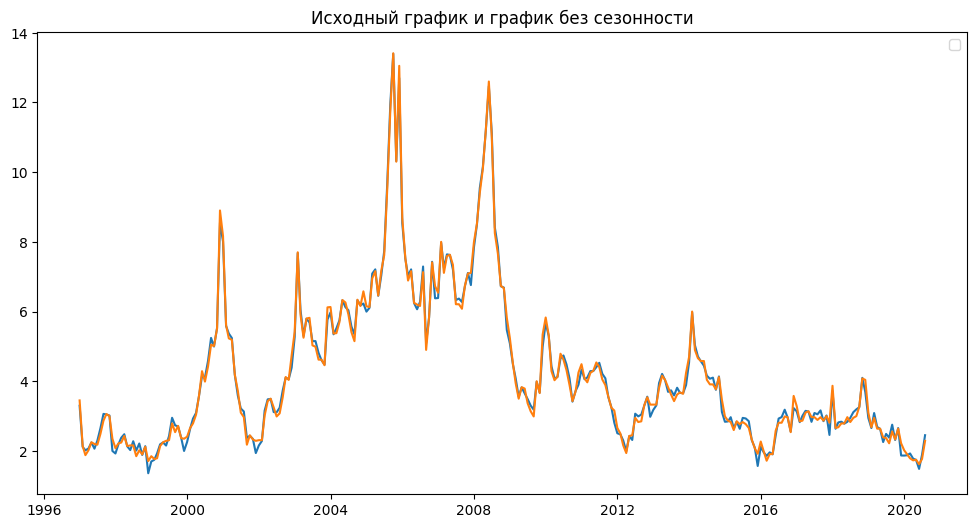

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(data[target_column]-decomposition.seasonal)
plt.plot(data[target_column])
plt.title('Исходный график и график без сезонности')
plt.legend()
plt.show()

В общем, можно сделать вывод о достаточно не значительном влиянии сезонности общую стоимость, т.к. графики практически сливаются, и различия заметны лишь в некоторых местах.

## Проверка стационарности ряда. Приведение к стационарному виду

In [16]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

adf_test(data[target_column])
static_data = (decomposition.resid).dropna()
adf_test(static_data)

ADF Statistic: -2.0525845114876007
p-value: 0.2640027547731365
Critical Values:
	1%: -3.4544435065994437
	5%: -2.8721468827772774
	10%: -2.572422013959188
ADF Statistic: -8.060847416991912
p-value: 1.6446043089864921e-12
Critical Values:
	1%: -3.4557539868570775
	5%: -2.8727214497041422
	10%: -2.572728476331361


На основе результатов теста Дики-Фуллера можно сделать вывод, что временной ряд не является стационарным.

Для приведения ряда к стационарному виду исключаем из ряда сезонность, и тренд. После выполнения этой операции ряд успешно проходит проверку стационарности.

Теперь p-value составляет 1.6446e-12 , что значительно ниже стандартного порога в 0.05. Критические значения для различных уровней значимости:
1%: -3.4558
5%: -2.8727
10%: -2.5727
Значение ADF Statistic (-8.0608) значительно меньше всех критических значений, что подтверждает, что можно отклонить нулевую гипотезу о нестационарности.

## AR (Autoregressive Model, авторегрессионная модель)


In [17]:
best_aic, best_bic, best_order_ar = float("inf"), float("inf"), None
for p in range(0, 30):
    model = AutoReg(static_data, lags=p).fit()
    if model.aic < best_aic:
        best_aic = model.aic
        best_order_ar = p
    if model.bic < best_bic:
        best_bic = model.bic
        best_order_ar_bic = p
print(f"Лучшая модель AR: порядок p={best_order_ar} по AIC={best_aic} и p={best_order_ar_bic} по BIC={best_bic}")


Лучшая модель AR: порядок p=27 по AIC=440.32254810522744 и p=5 по BIC=513.8499576467249


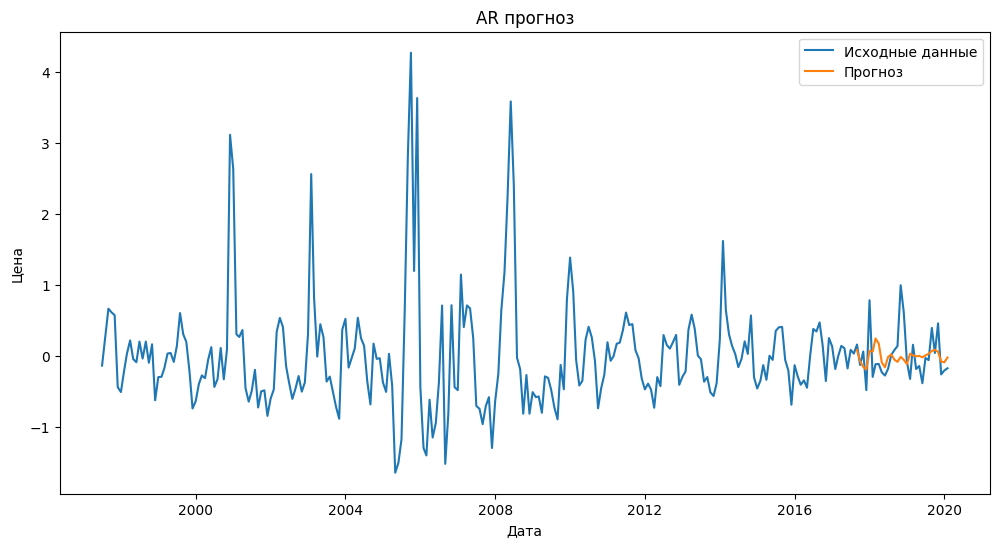

In [18]:
ar_model = AutoReg(static_data.iloc[-150:-30], lags = best_order_ar).fit()
ar_forecast = ar_model.forecast(30)
plt.figure(figsize=(12, 6))
plt.plot(static_data, label='Исходные данные')
plt.plot(static_data.index[-30:], ar_forecast, label='Прогноз')
plt.title('AR прогноз')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()

In [19]:
get_stats(static_data,ar_forecast,30)

MAE: 0.24589713712693204
RMSE: 0.3293943067628058
MAPE: 1.1218304366802674


Метрики качества MAE, RMSE и MAPE указывают на относительно невысокую точность прогноза. MAPE и вовсе превышает 100%.

## MA (Moving Average Model, модель скользящего среднего)

In [ ]:
best_aic, best_bic, best_order_MA = float("inf"), float("inf"), None
for q in range(1, 30):
    model = ARIMA(static_data, order=(0, 0, q)).fit()
    if model.aic < best_aic:
        best_aic = model.aic
        best_order_MA = q
    if model.bic < best_bic:
        best_bic = model.bic
        best_order_bic = q

print(f"Лучшая модель MA: порядок q={best_order_MA} по AIC={best_aic} и q={best_order_bic} по BIC={best_bic}")


Лучшая модель MA: порядок q=25 по AIC=451.9426407112684 и q=7 по BIC=504.25228777887446


In [ ]:
def display_forecast_ARIMA(title, order):
    model = ARIMA(static_data.iloc[:-30], order = order).fit()
    forecast = model.forecast(30)
    plt.figure(figsize=(12, 6))
    plt.plot(static_data[-60:], label='Исходные данные')
    plt.plot(static_data.index[-30:], forecast, label='Прогноз')
    plt.title(title)
    plt.xlabel('Дата')
    plt.ylabel('Цена')
    plt.legend()
    plt.show()
    get_stats(static_data, forecast, 30)

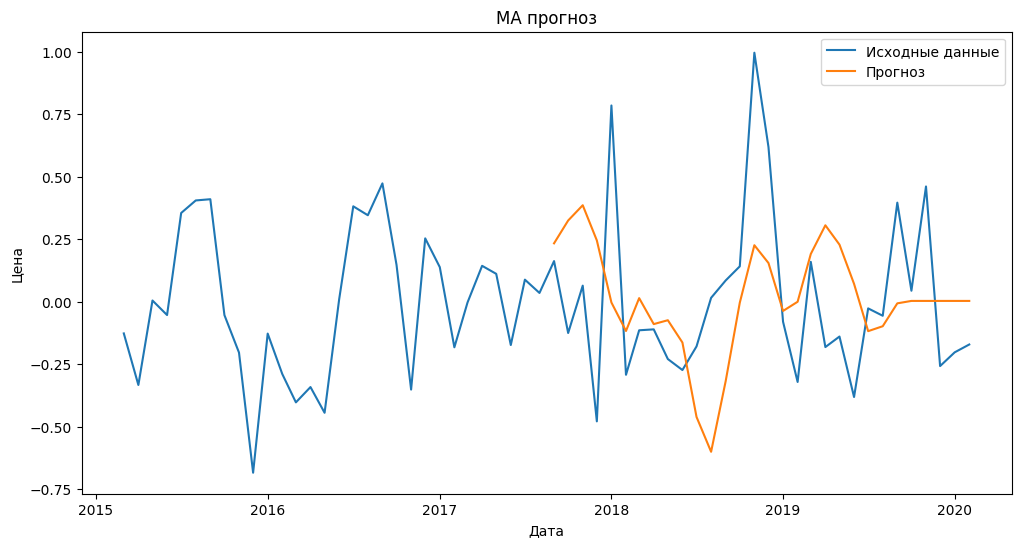

MAE: 0.30009831013479293
RMSE: 0.37406477691834356
MAPE: 2.781690895456758


In [ ]:
display_forecast_ARIMA('MA прогноз', (0,0,25))

Хотя график выглядит не так уж и плохо, метрики качества говорят об обратном - средняя ошибка достаточно велика относительно значений временного ряда, а MAPE и вовсе превышает 200%! Данная модель и прогноз абсолютно непригодны!

# ARMA (Autoregressive Moving Average, модель авторегрессии и скользящего среднего)

In [ ]:
arma_orders = arma_order_select_ic(static_data, ic=['aic', 'bic'], max_ar=30,max_ma=30)
best_aic_order = arma_orders['aic_min_order']
best_bic_order = arma_orders['bic_min_order']

print(f"Лучшая модель ARMA по AIC: порядок (p, q)={best_aic_order}")
print(f"Лучшая модель ARMA по BIC: порядок (p, q)={best_bic_order}")

Лучшая модель ARMA по AIC: порядок (p, q)=(np.int64(20), np.int64(7))
Лучшая модель ARMA по BIC: порядок (p, q)=(np.int64(20), np.int64(7))


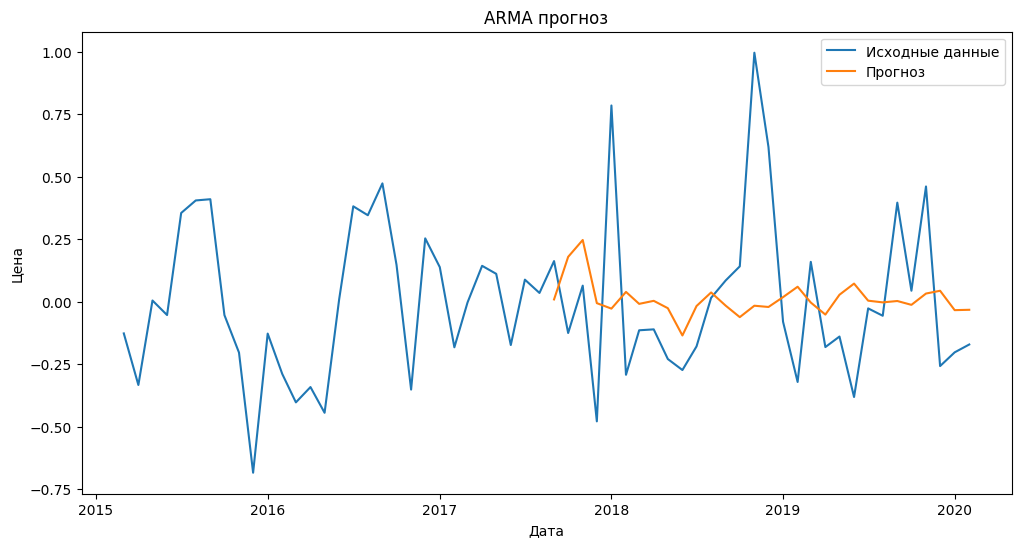

MAE: 0.264088521863653
RMSE: 0.34908600853932487
MAPE: 1.1465814529444025


In [ ]:
display_forecast_ARIMA('ARMA прогноз', (20,0,7))

В данном случае ситуация значительно лучше. MAPE уже не 278% а всего лишь 114%, но это всё ещё слишком большое значение. Значения ошибок также велики. Прогноз непригоден.

## ARIMA (Autoregressive Integrated Moving Average, авторегрессивная интегрированная модель скользящего среднего)

В отличие от других моделей ARIMA предполагает дифференцирование временного ряда, поэтому способна работать и с нестационарными временными рядами. Главное чтобы в результате дифференцирование ряд стал стационарным.

In [ ]:
best_aic, best_bic, best_order_arima = float("inf"), float("inf"), None
for p in range(best_order_ar_bic-4, best_order_ar_bic+4):
    for q in range(best_order_MA-4, best_order_MA+4):
        model = ARIMA(static_data, order=(p, 1, q)).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_order_arima = (p, 1, q)
        if model.bic < best_bic:
            best_bic = model.bic
            best_order_bic = (p, 1, q)

In [ ]:
print(f"Лучшая модель ARIMA по AIC = {best_aic}; порядок (p, d, q)={best_order_arima}")
print(f"Лучшая модель ARIMA по BIC = {best_bic}; порядок (p, d, q)={best_order_bic}")

Лучшая модель ARIMA по AIC = 81.92418884328664; порядок (p, d, q)=(28, 1, 24)
Лучшая модель ARIMA по BIC = 136.25749231155547; порядок (p, d, q)=(23, 1, 25)


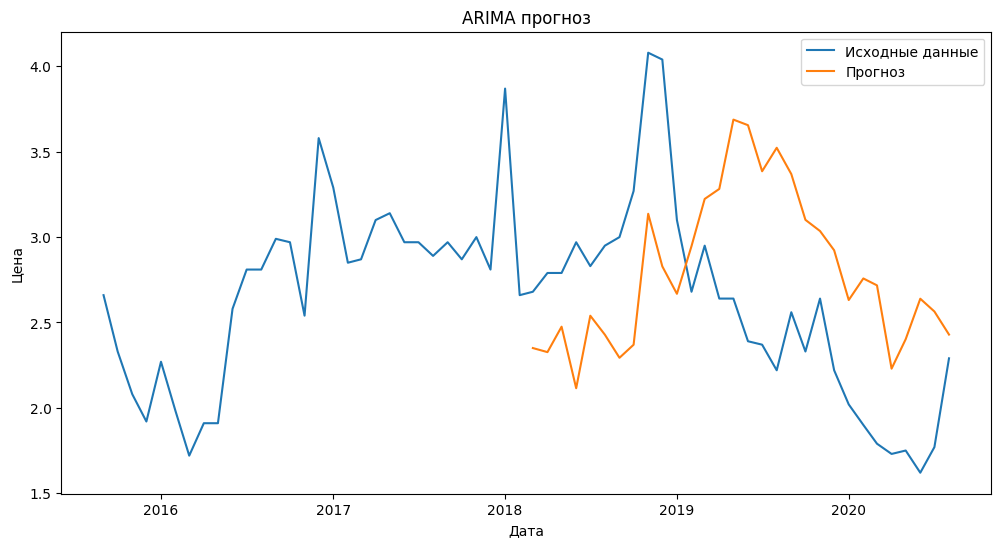

MAE: 0.6988282904315635
RMSE: 0.7656729084026235
MAPE: 0.2904842435388742


In [ ]:
model = ARIMA(data[target_column].iloc[:-30], order = best_order_arima).fit()
forecast = model.forecast(30)
plt.figure(figsize=(12, 6))
plt.plot(data[target_column][-60:], label='Исходные данные')
plt.plot(data[target_column].index[-30:], forecast, label='Прогноз')
plt.title("ARIMA прогноз")
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()
get_stats(data[target_column], forecast, 30)

По сравнению с другими моделями ARIMA показала очень достойный результат, хотя значения ошибок остаются достаточно большими.

## Заключение

Наилучший результат показала модель основная на экспоненциальном сглаживании. Также относительно неплохие результаты показала модель ARIMA.

Остальные модели AR, MA, ARMA, показали очень плохие результаты - MAPE > 100%, а MAE и RMSE очень велики относительно временного ряда.

Модели ARMA и ARIMA предполагают линейные зависимости в данных. Однако цены на газ и нефть часто подвержены нелинейным эффектам, таким как резкие скачки, которые могут быть вызваны геополитическими событиями, изменениями в спросе и предложении или другими факторами. Эти модели не могут адекватно захватывать такие сложности. Цены могут подвержены долгосрочным циклам, которые не всегда легко моделируются.

Подобные модели подходят гораздо лучше для куда более линейных и стационарных процессов. Например:
- Потребление электроэнергии
- Температура производственной машины
- Запасы товаров на складе


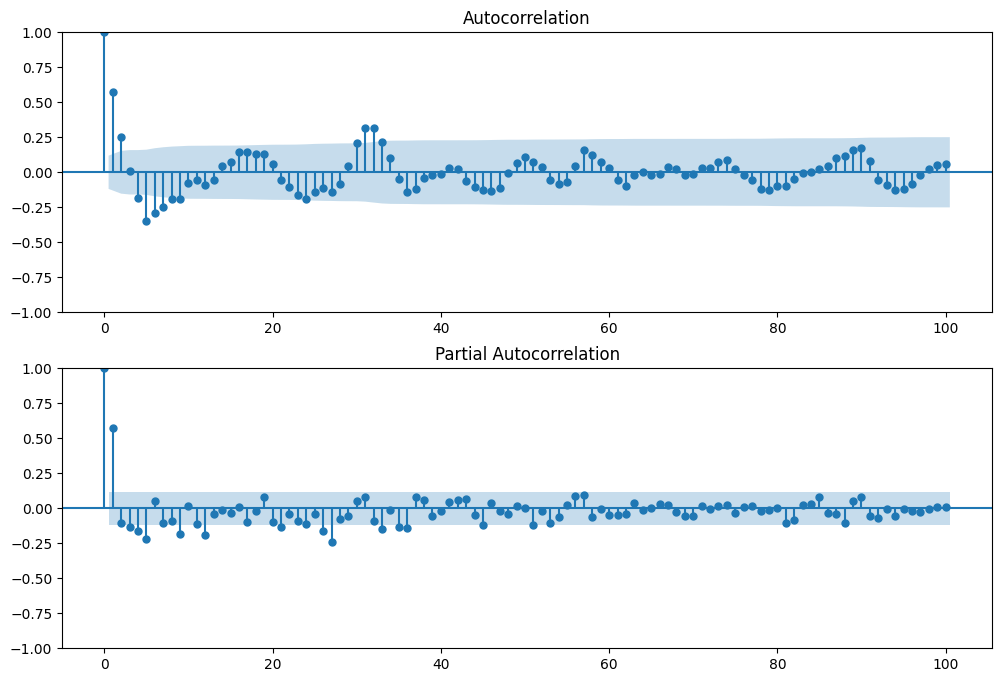

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(static_data, ax=ax1, lags=100)
plot_pacf(static_data, ax=ax2, lags=100)
plt.show()
